In [1]:
import fitsio
import numpy as np
import matplotlib.pyplot as plt
import sys, os

import seaborn as sns
sns.set()

# Intro

This notebook intents to summarize the steeps taken to hands up DESI coding environment and the desi target catalogues (`DESITARGET`). We will explain how to install the desi kernel that contains all the DESI modules needed to work in DESI. Then we will explain the basic of DESITARGET code and how to run it for a particular case. Finally we will work around with the output data finding interesting facts about the selections.

# Set up DESI code environments

Setup the DESI code environment with:
* source /project/projectdirs/desi/software/desi_environment.sh 19.2

Then install DESI Jupyter kernel definitions:
* ${DESIMODULES}/install_jupyter_kernel.sh 19.2

* ${DESIMODULES}/install_jupyter_kernel.sh master

More info on how to install the DESI Jupyter kernel and how to use the notebooks can be found here:
https://desi.lbl.gov/trac/wiki/Computing/JupyterAtNERSC

# How to run DESITARGET

In addition to the DESI Main Survey, desitarget produces targets for Commissioning (`CMX`) and Survey Validation (`SV`). However, in this notebook we will ignore the `CMX`.

## Synch and modify DESITARGET local

The main module that performs the selection work for desitarget is called `cuts`. All the the target classes are defined here along with their bits definitions. It also contains many usefull definitions for target selection that can be called directly from Python. The `cuts` files for the `main` and `SV` selections can be found here:

* https://github.com/desihub/desitarget/blob/master/py/desitarget/cuts.py (MAIN)
* https://github.com/desihub/desitarget/blob/master/py/desitarget/sv1/sv1_cuts.py (SV)

The targets bit mask are defined in the `yaml` files here:

* https://github.com/desihub/desitarget/blob/master/py/desitarget/data/targetmask.yaml (MAIN) 
* https://github.com/desihub/desitarget/blob/master/py/desitarget/sv1/data/sv1_targetmask.yaml (SV)

First of all, we need to Synch our local DESITARGET with the upstream repository to keep it up-to-date. To do so we execute:

    git remote add origin https://github.com/user/repo.git
    git remote add upstream https://github.com/desihub/desitarget.git
    git remote -v
    git fetch upstream
    git checkout master
    git merge upstream/master
    
or follow: https://help.github.com/en/articles/syncing-a-fork

Then, I recommend to create a new branch to work on based on updated master branch.

    git checkout -b <name of your new branch>

Info :https://github.com/Kunena/Kunena-Forum/wiki/Create-a-new-branch-with-git-and-manage-branches

Once we have modified the files, add the changes, commit and push:

    git status
    git add file
    git commit -m <COMMENT HERE>
    git push origin <NAME OF CURRENT BRANCH>
    

## Run DESITARGET to select targets and make QA plots

For the purposse of this notebook whe're going to create a subset of target files. This subset include only BGS targets in a circular patch with radius of $1$ deg and centred at RA$=121$, DEC$=15$. We're going to create targets from the `main` (baseline) selection and from the `SV` selection with their respectives QA plots.

A bash example is available here:

* /global/project/projectdirs/desi/users/qmxp55/uk_desi_meeting_sept_2019/run.sh

Note that this needs to be eddited to include your paths, in principle it will work as it is because the permissions allows it but it might be good to change the output directories at:

    export PATH=$PATH:<path to yout desitarget>/bin
    export PYTHONPATH=$PYTHONPATH:<path_to_yout_des:<itarget>/py
    export TARGDIR='/global/cscratch1/sd/<your_username>/desitarget_output'
    export WEBDIR='/global/cscratch1/sd/<your_username>/desitarget_output/WEB'

A complete tutorial on how to run `DESITARGET` by Adam M. can be found here: 
* https://github.com/desihub/desitarget/blob/master/doc/nb/how-to-run-target-selection.ipynb


In [2]:
!cat run.sh

#!/bin/bash

module load python/3.7-anaconda-2019.07
module unload desimodules
source /project/projectdirs/desi/software/desi_environment.sh 18.7
export PATH=$PATH:/global/homes/q/qmxp55/DESI/desitarget/bin
export PYTHONPATH=$PYTHONPATH:/global/homes/q/qmxp55/DESI/desitarget/py

export LSDIR='/global/project/projectdirs/cosmo/data/legacysurvey/dr8/south'
export TARGDIR='/global/cscratch1/sd/qmxp55/desitarget_output'
export WEBDIR='/global/cscratch1/sd/qmxp55/desitarget_output/WEB'
export DR='8.0'
export VERSION='1'
export PIXWEIGHT='/project/projectdirs/desi/target/catalogs/dr8/0.31.1/pixweight'
export BIN='/global/homes/q/qmxp55/DESI/desitarget/bin'

python $BIN/select_targets $LSDIR/sweep/$DR/ $TARGDIR/targets-dr$DR-$VERSION.fits --tcnames BGS --radecrad 121,15,1 --nosecondary
python $BIN/select_sv_targets $LSDIR/sweep/$DR $TARGDIR/targets-sv-dr$DR-$VERSION.fits --tcnames BGS --radecrad 121,15,1 --nosecondary

python $BIN/run_target_qa $TARGDIR/bright/targets-dr$DR-$VERSION.fits $WEB

Since this example doesn't take to much time ($\sim 6$ min), you can executed straight from the notebook:

    !sh run.sh
    
remember to change permissions on the file if other people will use it, e.g.:

    chgrp desi *fits ; chmod 660 *fits

In [28]:
!chgrp desi /global/cscratch1/sd/qmxp55/desitarget_output

# Load and manipulate DESITARGET output catalogues

The output files are available at NERSC in the directories:

* /project/projectdirs/desi/target/catalogs/dr8/0.31.0 (for randoms and skies)
* /project/projectdirs/desi/target/catalogs/dr8/0.31.1 (for everything else)


## Extract a subset of targets from DESITARGET output catalogues

DESITARGET allows to extract a subset of targets from a patch in the sky. The patch can be a box, a circle or a healpix pixel. In our test we have choose to extrac a circular patch with radius of $2$ deg and centred at $121$ in RA and $18$ in DEC.

In [3]:
from desitarget.io import read_targets_in_hp, read_targets_in_box, read_targets_in_cap, check_hp_target_dir

In [4]:
#Load sample of resolve DR8 target catalogue
hpdirname = '/project/projectdirs/desi/target/catalogs/dr8/0.31.1/targets/main/resolve'

# Read targets in an RA, Dec, radius (degrees) "circle".
radecrad = [121,18,2]
captargs = read_targets_in_cap(hpdirname, radecrad)

print('# rows = %i' %(len(captargs)))
print('# cols = %i' %(len(captargs.dtype.names)))

# rows = 88584
# cols = 104


The default option for extracting targets is to return all columns in a target file, but it's also possible to return just a subset of columns by passing them as a list.

## Load the whole DESITARGET output catalogue

The official DESITARGET output target catalogue was run in parallel and it is divided into healpix pixels fits files. To read the whole catalogue in python we use the functions `check_hp_target_dir` and `read_targets_in_hp`. 

From previous catalogue subset we saw that DESITARGET catalogues contain $104$ cols, since we are trying to load the whole DESI footrpint, for speed purposses we include a list of cols to be extracted instead of all.


In [10]:
#use this to check the properties of the hp directory
nside, pixdict = check_hp_target_dir(hpdirname)

#Load full DR8 target catalogue
columns = ['RA', 'DEC', "DESI_TARGET", "TARGETID"]
mastertargs = read_targets_in_hp(hpdirname=hpdirname, nside=nside, 
                               pixlist=np.array(list(pixdict.keys())), columns=columns)

print('# rows = %i' %(len(mastertargs)))
print('# cols = %i' %(len(mastertargs.dtype.names)))

# rows = 123285320
# cols = 4


## Main Survey bitmasks

The critical values that select_targets produces are the `DESI_TARGET`, `BGS_TARGET` and `MWS_TARGET` bit masks, which contain the target bits for the DESI main (or "dark time") survey and the Bright Galaxy Survey and Milky Way Survey respectively. Let's examine the masks that correspond to these surveys.

In [5]:
#load the bit maks dictionaries
from desitarget.targets import desi_mask, bgs_mask, mws_mask
from astropy.table import Table

names = desi_mask.names()
bitnums = [desi_mask.bitnum(name) for name in names]
bitvals = [desi_mask[name] for name in names]
#list(zip(names,bitnums,bitvals)) # ADM the bit and integer value for each defined name.

desi_mask_tab = Table()
desi_mask_tab['name'], desi_mask_tab['bitnums'], desi_mask_tab['bitvals'] = names, bitnums, bitvals
desi_mask_tab

name,bitnums,bitvals
str18,int64,int64
LRG,0,1
ELG,1,2
QSO,2,4
LRG_NORTH,8,256
ELG_NORTH,9,512
QSO_NORTH,10,1024
LRG_SOUTH,16,65536
ELG_SOUTH,17,131072
QSO_SOUTH,18,262144


These values are defined here in DESITARGET: https://github.com/desihub/desitarget/blob/master/py/desitarget/data/targetmask.yaml

We can do the same for `bgs_mask`, `mws_mask`.

Below we define boolean arrays with the main DESI target classes, ELG's, QSO's, LRG's and BGS.

In [6]:
#DESI target classes
isELG = (captargs["DESI_TARGET"] & desi_mask["ELG"]) != 0
isQSO = (captargs["DESI_TARGET"] & desi_mask["QSO"]) != 0
isLRG = (captargs["DESI_TARGET"] & desi_mask["LRG"]) != 0
isBGS = (captargs["DESI_TARGET"] & desi_mask["BGS_ANY"]) != 0


The above can also be difined with (e.g., BGS):

In [7]:
#another way of define BGS targets
isBGS_test = (captargs["DESI_TARGET"] & 2**60) != 0
print('Are both definitons of BGS equivalent?')
list(captargs['TARGETID'][isBGS]) == list(captargs['TARGETID'][isBGS_test])

Are both definitons of BGS equivalent?


True

We can plot each of the targets in the sky to see how they distribute, and a histogram to see their distribution in number counts.

Text(0,0.5,'$f$')

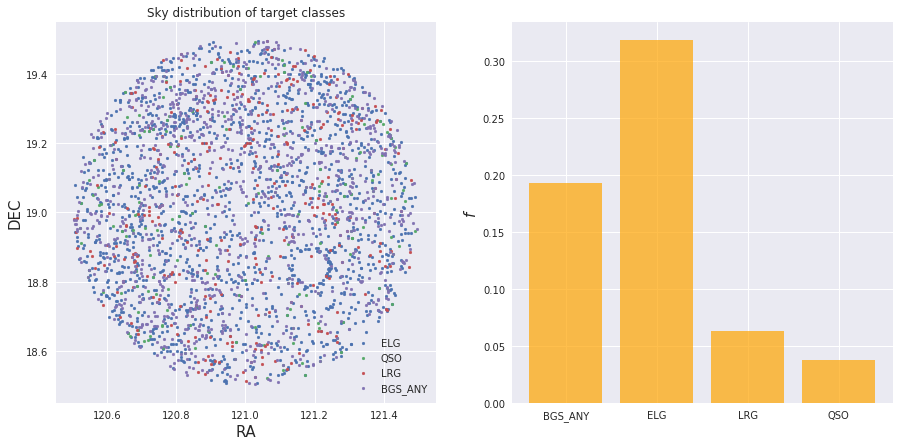

In [8]:
plt.figure(figsize=(15,7))

plt.subplot(1,2,1)
targ_list = {'ELG':isELG, 'QSO':isQSO, 'LRG':isLRG, 'BGS_ANY':isBGS}
for key, val in zip(targ_list.keys(), targ_list.values()):
    
    mask = val.copy() #(captargs["DESI_TARGET"] & desi_mask[target]) != 0
    mask &= ((121 - captargs['RA'])**2 + (19 - captargs['DEC'])**2 ) < 0.5**2
    
    plt.scatter(captargs['RA'][mask], captargs['DEC'][mask], s=8, label=key)
plt.xlabel(r'RA', size=15)
plt.ylabel(r'DEC', size=15)  
plt.legend()
plt.title(r'Sky distribution of target classes')

plt.subplot(1,2,2)
plt.bar(targ_list.keys(), [np.sum(i)/len(captargs) for i in targ_list.values()], color='orange', alpha=0.7)
#np.sum(isELG | isQSO | isLRG | isBGS)
plt.ylabel(r'$f$', size=15)


### Dark Survey overlap with BGS

Lets look how much overlap do BGS have with the Dark time survey.

In [9]:
for key, val in zip(list(targ_list.keys())[:-1], list(targ_list.values())[:-1]):
    print('BGS overlap with %s: N=%d, ~%g %% out of total in BGS' 
      %(key ,np.sum((isBGS) & (val)), 100*np.sum((isBGS) & (val))/np.sum(isBGS)))

BGS overlap with ELG: N=15, ~0.0878272 % out of total in BGS
BGS overlap with QSO: N=400, ~2.34206 % out of total in BGS
BGS overlap with LRG: N=991, ~5.80245 % out of total in BGS


In [10]:
def flux_to_mag(flux):
    mag = 22.5 - 2.5*np.log10(flux)
    return mag

rmag = flux_to_mag(captargs['FLUX_R']/captargs['MW_TRANSMISSION_R'])

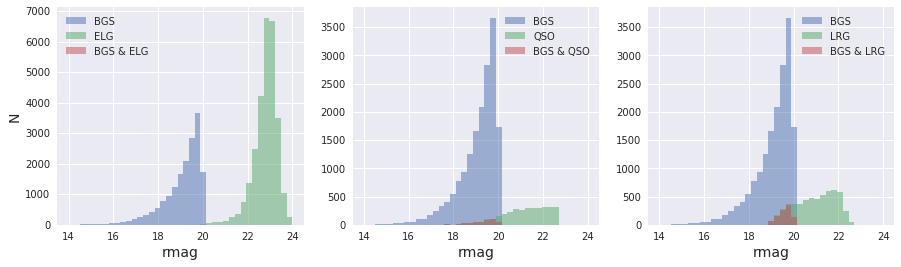

In [11]:
#
plt.figure(figsize=(15, 4))

bins = np.linspace(14, 24, 40)
for key, val, i in zip(list(targ_list.keys())[:-1], list(targ_list.values())[:-1], [1,2,3]):

    plt.subplot(1, 3, i)
    plt.hist(rmag[isBGS], bins=bins, alpha=0.5, label=r'BGS')
    plt.hist(rmag[val], bins=bins, alpha=0.5, label=key)
    plt.hist(rmag[(isBGS) & (val)], bins=bins, alpha=0.5, label=r'BGS & %s' %(key))
    plt.legend()
    plt.xlabel(r'rmag', size=14)
    if i == 1:
        plt.ylabel(r'N', size=14)


## DESITARGET for SV

In addition to the DESI Main Survey, desitarget produces targets for Commissioning ("CMX") and Survey Validation ("SV"). The CMX and SV bitmasks can be obtained and examined as follows (other manipulation of these masks is similar to the previous sub-section, above):

In [12]:
from desitarget.sv1.sv1_targetmask import desi_mask, bgs_mask, mws_mask
#desi_mask.names()

names = desi_mask.names()
bitnums = [desi_mask.bitnum(name) for name in names]
bitvals = [desi_mask[name] for name in names]
#list(zip(names,bitnums,bitvals)) # ADM the bit and integer value for each defined name.

desi_mask_tab = Table()
desi_mask_tab['name'], desi_mask_tab['bitnums'], desi_mask_tab['bitvals'] = names, bitnums, bitvals
desi_mask_tab

name,bitnums,bitvals
str21,int64,int64
LRG,0,1
ELG,1,2
QSO,2,4
LRG_INIT_4PASS,3,8
LRG_SUPER_4PASS,4,16
LRG_INIT_8PASS,5,32
LRG_SUPER_8PASS,6,64
LOWZ_FILLER,7,128
ELG_FDR,8,256


Like the Main survey target catalogue, SV files have the columns SV1_DESI_TARGET, SV1_BGS_TARGET and SV1_MWS_TARGET.

In [13]:
#Load sample of resolve DR8 SV target catalogue
hpdirname_sv1 = '/project/projectdirs/desi/target/catalogs/dr8/0.31.1/targets/sv/resolve'

# Read targets in an RA, Dec, radius (degrees) "circle".
radecrad = [121,18,2]
captargs_sv1 = read_targets_in_cap(hpdirname_sv1, radecrad)

### exercices: overlap in SV

Following previous excercice, we look at the overlap between BGS and the dark time survey targets.

In [14]:
#DESI target classes for SV
isELG_sv1 = (captargs_sv1["SV1_DESI_TARGET"] & desi_mask["ELG"]) != 0
isQSO_sv1 = (captargs_sv1["SV1_DESI_TARGET"] & desi_mask["QSO"]) != 0
isLRG_sv1 = (captargs_sv1["SV1_DESI_TARGET"] & desi_mask["LRG"]) != 0
isBGS_sv1 = (captargs_sv1["SV1_DESI_TARGET"] & desi_mask["BGS_ANY"]) != 0

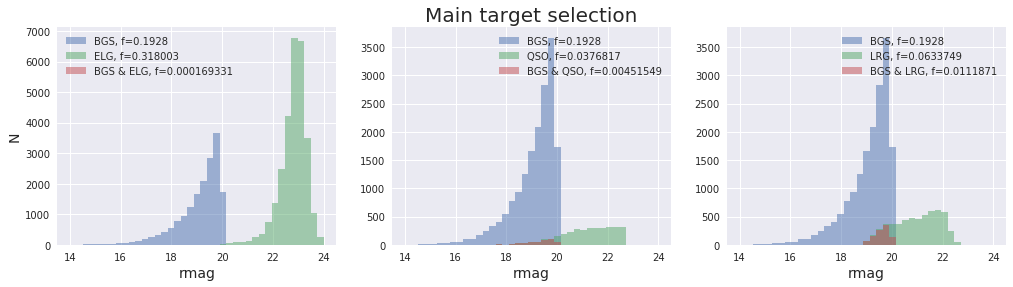

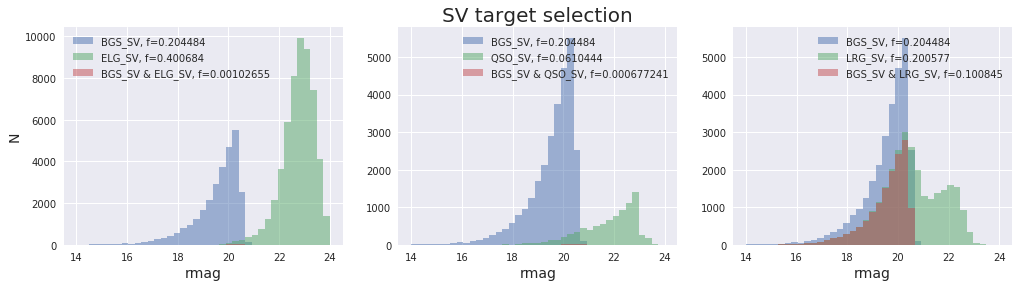

In [15]:
targ_list_sv1 = {'ELG_SV':isELG_sv1, 'QSO_SV':isQSO_sv1, 'LRG_SV':isLRG_sv1, 'BGS_ANY_SV':isBGS_sv1}
rmag_sv1 = flux_to_mag(captargs_sv1['FLUX_R']/captargs_sv1['MW_TRANSMISSION_R'])

#
plt.figure(figsize=(17, 4))

bins = np.linspace(14, 24, 40)
for key, val, i in zip(list(targ_list.keys())[:-1], list(targ_list.values())[:-1], [1,2,3]):

    plt.subplot(1, 3, i)
    plt.hist(rmag[isBGS], bins=bins, alpha=0.5, label=r'BGS, f=%g' %(np.sum(isBGS)/len(rmag)))
    plt.hist(rmag[val], bins=bins, alpha=0.5, label=r'%s, f=%g' %(key, np.sum(val)/len(rmag)))
    plt.hist(rmag[(isBGS) & (val)], bins=bins, alpha=0.5, label=r'BGS & %s, f=%g' %(key, np.sum((isBGS) & (val))/len(rmag)))
    plt.legend()
    plt.xlabel(r'rmag', size=14)
    if i == 1:
        plt.ylabel(r'N', size=14)
    if i == 2:
        plt.title(r'Main target selection', size=20)
plt.show()

#
plt.figure(figsize=(17, 4))

for key, val, i in zip(list(targ_list_sv1.keys())[:-1], list(targ_list_sv1.values())[:-1], [1,2,3]):

    plt.subplot(1, 3, i)
    plt.hist(rmag_sv1[isBGS_sv1], bins=bins, alpha=0.5, label=r'BGS_SV, f=%g' %(np.sum(isBGS_sv1)/len(rmag_sv1)))
    plt.hist(rmag_sv1[val], bins=bins, alpha=0.5, label=r'%s, f=%g' %(key, np.sum(val)/len(rmag_sv1)))
    plt.hist(rmag_sv1[(isBGS_sv1) & (val)], bins=bins, alpha=0.5, label=r'BGS_SV & %s, f=%g' %(key, np.sum((isBGS_sv1) & (val))/len(rmag_sv1)))
    plt.legend()
    plt.xlabel(r'rmag', size=14)
    if i == 1:
        plt.ylabel(r'N', size=14)
    if i == 2:
        plt.title(r'SV target selection', size=20)
plt.show()

One thing that quickly turn our attention is the high overlap between BGS targets and LRG targets in SV. Using the postage images wraper at: we can create a gallery of targets in the overlap region to visualy inspect them.


In [16]:
from postages_images import postages_circle

Colour key:
	 BGS&LRG --> lime
	 ELG --> royalblue
	 QSO --> purple
	 other --> red


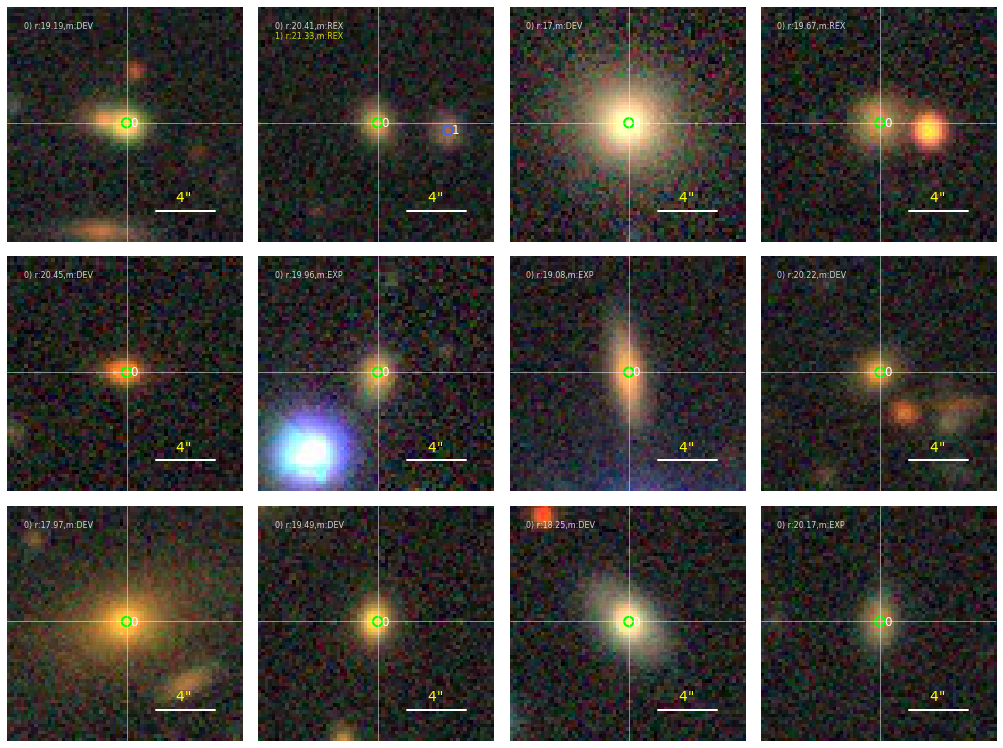

In [17]:
#Get the postages...
#veto = {'BGS':isBGS_sv1, 'LRG':isLRG_sv1, 'BGS&LRG':(isBGS_sv1) & (isLRG_sv1), 'ELG':isELG_sv1, 'QSO':isQSO_sv1}
veto = {'BGS&LRG':(isBGS_sv1) & (isLRG_sv1), 'ELG':isELG_sv1, 'QSO':isQSO_sv1}
info = {'r':rmag_sv1, 'm':captargs_sv1['MORPHTYPE'].astype(str)} #'ref':df['REF_CAT']
layer_dr7='decals-dr7'
layer_dr8='dr8'

#indexes of BGS & LRG overlap
idx = list(np.where((isBGS_sv1) & (isLRG_sv1)))[0]

#if we want to compare the same objects with another catalogue (i.e., DR7, DR8) select only
#the right number of indexes as your grid to avoid the random selection in postages_circle.
postages_circle(coord=[captargs_sv1['RA'], captargs_sv1['DEC']], centeridx=idx, veto=veto, info=info, scale=0.262, 
                scale_unit='pixscale', layer=layer_dr8, radius=1.5/3600., m=6, grid=[3,4], 
                savefile='bgs_lrg_sv_overlap', layer2=None, layer2Mode='separate', isLG=False, title=None)

### exercice: find the clossets DT targets to BGS

Now lets see what are the closest dark time targets to BGS galaxies within a searching radius of 3 arcsec.

In [18]:
from astropy.coordinates import SkyCoord
from astropy import units as u

def search_around(ra1, dec1, ra2, dec2, search_radius=1., verbose=True):
    '''
    Using the astropy.coordinates.search_around_sky module to find all pairs within
    some search radius.
    Inputs:
    RA and Dec of two catalogs;
    search_radius (arcsec);
    Outputs:
        idx1, idx2: indices of matched objects in the two catalogs;
        d2d: angular distances (arcsec);
        d_ra, d_dec: the differences in RA and Dec (arcsec);
    '''

    # protect the global variables from being changed by np.sort
    ra1, dec1, ra2, dec2 = map(np.copy, [ra1, dec1, ra2, dec2])

    # Matching catalogs
    sky1 = SkyCoord(ra1*u.degree,dec1*u.degree, frame='icrs')
    sky2 = SkyCoord(ra2*u.degree,dec2*u.degree, frame='icrs')
    idx1, idx2, d2d, d3d = sky2.search_around_sky(sky1, seplimit=search_radius*u.arcsec)
    if verbose:
        print('%d nearby objects ~ %g %%'%(len(idx1), 100*len(idx1)/len(ra2)))

    # convert distances to numpy array in arcsec
    d2d = np.array(d2d.to(u.arcsec))


    d_ra = (ra2[idx2]-ra1[idx1])*3600.    # in arcsec
    d_dec = (dec2[idx2]-dec1[idx1])*3600. # in arcsec
    ##### Convert d_ra to actual arcsecs #####
    mask = d_ra > 180*3600
    d_ra[mask] = d_ra[mask] - 360.*3600
    mask = d_ra < -180*3600
    d_ra[mask] = d_ra[mask] + 360.*3600
    d_ra = d_ra * np.cos(dec1[idx1]/180*np.pi)
    ##########################################

    return idx1, idx2, d2d, d_ra, d_dec

In [19]:
idx2, idx1, d2d, d_ra, d_dec = search_around(captargs_sv1['RA'], captargs_sv1['DEC'], captargs_sv1['RA'][isBGS_sv1], 
                                             captargs_sv1['DEC'][isBGS_sv1], search_radius=3)

29153 nearby objects ~ 101.635 %


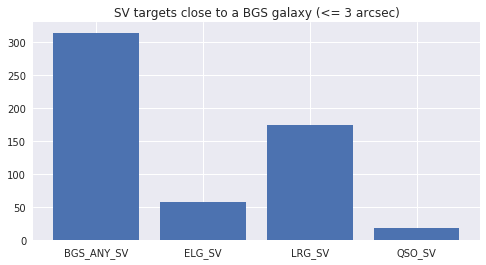

In [22]:
#bar plot
plt.figure(figsize=(8,4))
plt.bar(targ_list_sv1.keys(), [np.sum(i[idx2[d2d > 0]]) for i in targ_list_sv1.values()])
plt.title(r'SV targets close to a BGS galaxy (<= 3 arcsec)')
plt.show()

Colour key:
	 BGS --> lime
	 LRG --> royalblue
	 ELG --> purple
	 QSO --> orange
	 other --> red


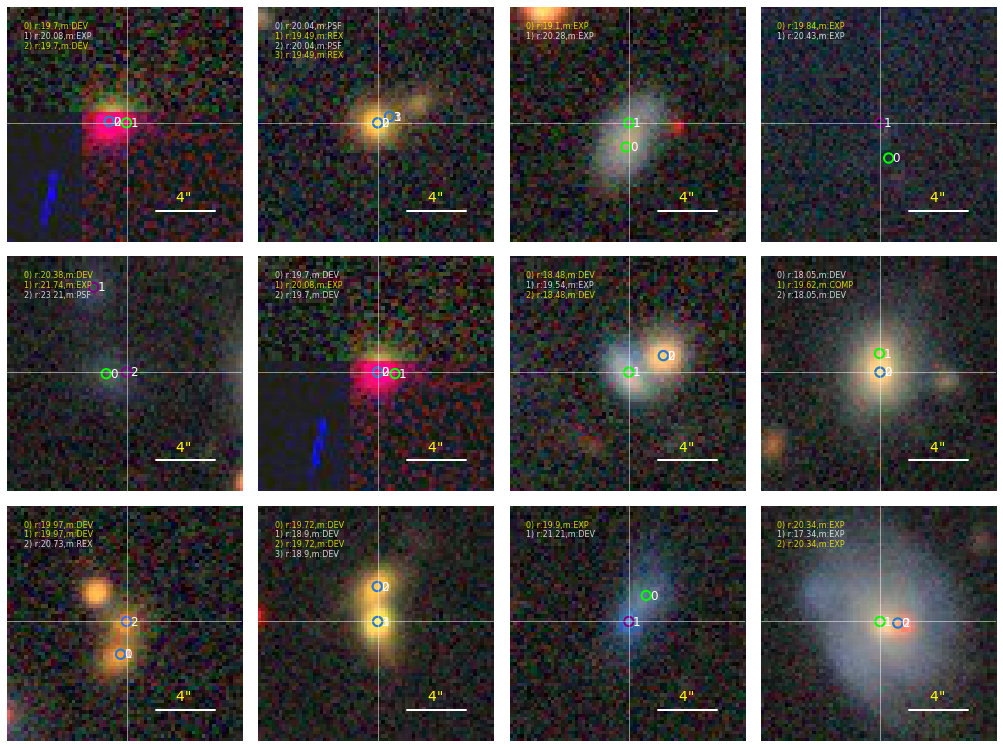

In [23]:
### Get the postages...
veto = {'BGS':isBGS_sv1, 'LRG':isLRG_sv1, 'ELG':isELG_sv1, 'QSO':isQSO_sv1}
info = {'r':rmag_sv1, 'm':captargs_sv1['MORPHTYPE'].astype(str)} #'ref':df['REF_CAT']
layer_dr7='decals-dr7'
layer_dr8='dr8'

#indexes of BGS & LRG overlap
idx = idx2[d2d > 0]

#if we want to compare the same objects with another catalogue (i.e., DR7, DR8) select only
#the right number of indexes as your grid to avoid the random selection in postages_circle.
postages_circle(coord=[captargs_sv1['RA'], captargs_sv1['DEC']], centeridx=idx, veto=veto, info=info, scale=0.262, 
                scale_unit='pixscale', layer=layer_dr8, radius=1.5/3600., m=6, grid=[3,4], 
                savefile='dt_targets_close_to_bgs_3arcsec', layer2=None, layer2Mode='separate', isLG=False, title=None)